## Harpy distance calculations

In this notebook, we will perform some distance calculation for cells based on SpatialData Shapes. These shapes can be a collection of regions of interest or simple lines. These shapes can be obtained through manual annotation in viewers like napari.


In [1]:
import harpy as hp
import spatialdata as sd
import spatialdata_plot  # noqa

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
sdata = hp.datasets.cluster_blobs()
sdata

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/models/models.py:1048: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/_core/_elements.py:116: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


SpatialData object
├── Images
│     └── 'blobs_image': DataArray[cyx] (11, 512, 512)
├── Labels
│     └── 'blobs_labels': DataArray[yx] (512, 512)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 2) (2D points)
└── Tables
      └── 'table': AnnData (20, 11)
with coordinate systems:
    ▸ 'global', with elements:
        blobs_image (Images), blobs_labels (Labels), blobs_points (Points)

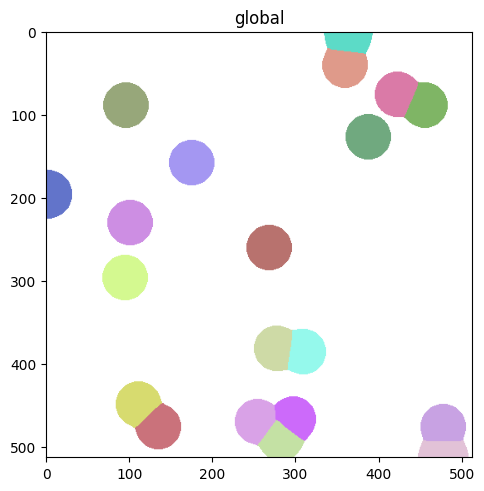

In [3]:
(sdata.pl.render_labels("blobs_labels").pl.show())

In [4]:
# add line and shape to simulate regions
import geopandas as gpd
from shapely.geometry import Polygon, LineString

# note the (x, y) coordinates of the Polygon. In the plotted image it shows x on the bottom and y on the left
roi1 = Polygon([(100, 200), (100, 300), (200, 300), (200, 200)]).buffer(10)
roi2 = Polygon([(300, 400), (300, 500), (400, 500), (400, 400)])
line = LineString([(250, 0), (250, 600)])

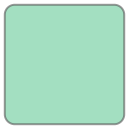

In [5]:
roi1

In [6]:
roi_df = gpd.GeoDataFrame(geometry=[roi1, roi2])
line_df = gpd.GeoDataFrame(geometry=[line])
roi_df

,geometry
0,"POLYGON ((100 190, 99.02 190.048, 98.049 190.1..."
1,"POLYGON ((300 400, 300 500, 400 500, 400 400, ..."


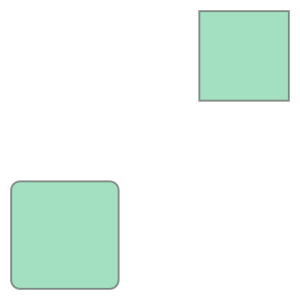

In [7]:
roi_df.union_all()

In [8]:
sdata["roi"] = sd.models.ShapesModel.parse(roi_df)

<Axes: title={'center': 'global'}>

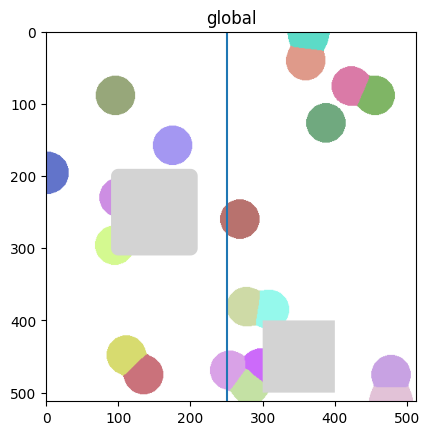

In [9]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

(sdata.pl.render_labels("blobs_labels").pl.render_shapes("roi").pl.show(ax=ax))
line_df.plot(ax=ax)

Plotting the Shapes is important to make sure that the coordinates are correct.

Now we want to calculate:

- the shortest distance for each cells to any of the two rectangular ROIs.
- the shortest distance for each cells to the line.

This is best expressed using [Shapely](https://shapely.readthedocs.io/en/stable/) and [Geopandas](https://geopandas.org/en/stable/getting_started.html) queries. So we will convert the cell labels from the segmentation mask to polygons and then calculate the distances.

To make sure that the distances are calculated correctly, we will plot the ROIs and the line and color the cells according to the distances.


In [10]:
sdata

SpatialData object
├── Images
│     └── 'blobs_image': DataArray[cyx] (11, 512, 512)
├── Labels
│     └── 'blobs_labels': DataArray[yx] (512, 512)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 2) (2D points)
├── Shapes
│     └── 'roi': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (20, 11)
with coordinate systems:
    ▸ 'global', with elements:
        blobs_image (Images), blobs_labels (Labels), blobs_points (Points), roi (Shapes)

In [11]:
cell_polygons = hp.sh.vectorize(
    sdata, labels_layer="blobs_labels", output_layer="blobs_shapes", overwrite=True
)  # (sdata["blobs_labels"].data)
cell_polygons["blobs_shapes"]

2024-12-09 09:07:25,351 - harpy.shape._manager - INFO - Finished vectorizing. Dissolving shapes at the border of the chunks. This can take a couple minutes if input mask contains a lot of chunks.
2024-12-09 09:07:25,355 - harpy.shape._manager - INFO - Dissolve is done.


,geometry
cell_ID,
1,"POLYGON ((249 442, 249 443, 246 443, 246 444, ..."
2,"POLYGON ((292 439, 292 440, 289 440, 289 441, ..."
3,"POLYGON ((106 421, 106 422, 103 422, 103 423, ..."
4,"POLYGON ((170 131, 170 132, 167 132, 167 133, ..."
5,"POLYGON ((276 468, 276 470, 275 470, 275 471, ..."
6,"POLYGON ((447 62, 447 67, 446 67, 446 70, 445 ..."
7,"POLYGON ((453 491, 453 493, 452 493, 452 495, ..."
8,"POLYGON ((302 358, 302 359, 297 359, 297 360, ..."
9,"POLYGON ((417 49, 417 50, 414 50, 414 51, 411 ..."


In [12]:
distances_to_roi = sdata["blobs_shapes"].geometry.distance(roi_df.union_all())
distances_to_roi

cell_ID
1      23.000000
2       0.000000
3     111.000000
4       4.000000
5       0.000000
6     239.771929
7      47.518417
8       0.000000
9     216.417967
10     58.000000
11      0.000000
12     73.000000
13    163.109646
14     50.000000
15      0.000000
16    187.284127
17    137.000000
18    216.024760
19      8.246211
20     31.000000
dtype: float64

In [13]:
from harpy.utils._keys import _INSTANCE_KEY
import numpy as np

# sanity check (check that table matches the created shapes layer, so that we are sure that distances are added to correct location)
assert np.array_equal(sdata["table"].obs[_INSTANCE_KEY].values, sdata["blobs_shapes"].index)

In [14]:
sdata["table"].obs["distance_to_roi"] = distances_to_roi.values

In [15]:
sdata["table"].obs["distance_to_line"] = sdata["blobs_shapes"].geometry.distance(line).values

<Axes: title={'center': 'global'}>

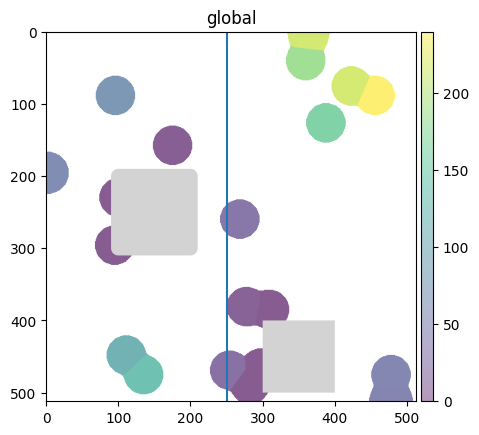

In [16]:
# since SpatialData supports Polygon but not LineString elements, we plot the line separately
fig, ax = plt.subplots()

(sdata.pl.render_labels("blobs_labels", color="distance_to_roi").pl.render_shapes("roi").pl.show(ax=ax))
line_df.plot(ax=ax)

<Axes: title={'center': 'global'}>

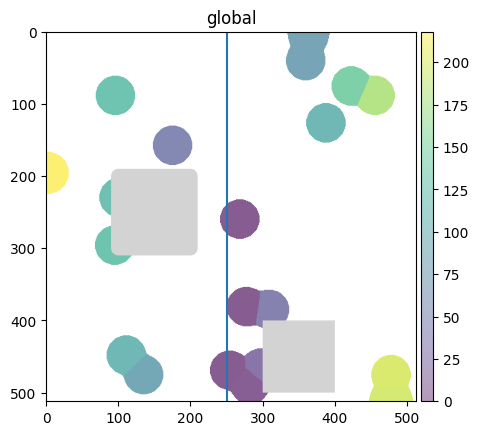

In [17]:
fig, ax = plt.subplots()

(sdata.pl.render_labels("blobs_labels", color="distance_to_line").pl.render_shapes("roi").pl.show(ax=ax))
line_df.plot(ax=ax)

We can see that the cells are colored according to the distance to the line and the two ROIs.

This simple example can be extended to calculate distance to e.g. tumor regions in a tissue. For additional distance analysis or spatial statistics, consider also the documentation of [Squidpy](https://squidpy.readthedocs.io/en/stable/notebooks/examples/index.html#graph) or [Sopa](https://gustaveroussy.github.io/sopa/tutorials/spatial/). 